In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from pathlib import Path
import numpy as np
import pandas as pd
import time
import pdb
from tqdm import tqdm, trange, tqdm_notebook
from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold
import pickle as pkl
import seaborn as sns
import matplotlib.pyplot as plt
import sys, os
import gc
from collections import defaultdict, Counter

In [3]:
plt.rcParams.update({'font.size': 16})

# Load Data

In [4]:
meta = pd.read_pickle('train.meta.covs.pickle')
meta.shape

(21988, 7)

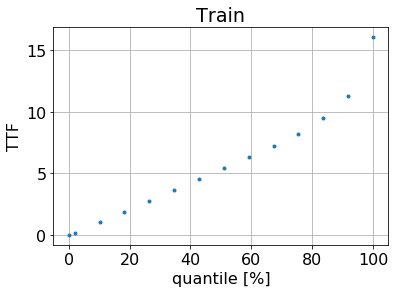

In [5]:
thres1 = 0.1917
q1 = np.mean(meta.qt<thres1)
thresholds = np.concatenate(((0, thres1), np.quantile(meta.qt[meta.qt>thres1], np.arange(0,1.01,1/12))[1:]))
plt.plot(np.concatenate(((0,), 100*(q1+(1-q1)*np.arange(0,1.01,1/12)))), thresholds, '.')
plt.title('Train')
plt.xlabel('quantile [%]')
plt.ylabel('TTF')
plt.grid()

In [6]:
meta['qt_class'] = [np.sum(t>thresholds) for t in meta.qt]
meta['qt_class_cent'] = list(map(lambda i: (thresholds[i-1]+thresholds[i])/2, meta['qt_class']))
Counter(meta.qt_class_cent)

Counter({1.4593893822125: 1796,
         0.6111491184708333: 1796,
         0.09585: 436,
         13.665638803583331: 1796,
         10.403197066383331: 1796,
         8.8820683843375: 1796,
         7.7248766976875: 1796,
         6.782463788741666: 1796,
         5.890222970991667: 1796,
         5.0007234800875: 1796,
         4.1130983853375: 1796,
         3.2227104645: 1796,
         2.331751463091667: 1796})

In [7]:
# plt.figure(figsize=(15,5))
# plt.scatter(x=np.arange(len(meta)), y=meta.qt, c=meta.qt_class)
# plt.grid()
# plt.xlabel('segment')
# plt.ylabel('TTF')
# plt.title('Train')

### Load Predictions & References

In [8]:
PREDS = Path('final_versions')

In [9]:
# public test segments indices
public_ids = np.load('is_public.npy')>0.5 # array of T/F
# out-of-sample train set predictions
p_train = pd.DataFrame({f'model_{i:02d}':np.load(PREDS/f'train-{i:02d}.npy') for i in range(4)})
# test set predictions
p_test = pd.DataFrame({f'model_{i:02d}':np.load(PREDS/f'predictions-{i:02d}.npy') for i in range(4)})
# test ttf reference ( = currently best submission)
test_ref = pd.read_csv('test_ref.csv').time_to_failure.values # array of estimated test ttf

In [10]:
p_test['anton'] = pd.read_csv('anton_submission.csv').time_to_failure
p_public = p_test.loc[public_ids]
p_private = p_test.loc[np.logical_not(public_ids)]
train_ref = meta.qt
public_ref = test_ref[public_ids]

n_train = len(p_train)
n_test = len(p_test)
n_public = len(p_public)
n_private = len(p_private)

In [11]:
print(p_train.shape)
print(p_public.shape)
print(p_private.shape)

(21988, 4)
(348, 5)
(2276, 5)


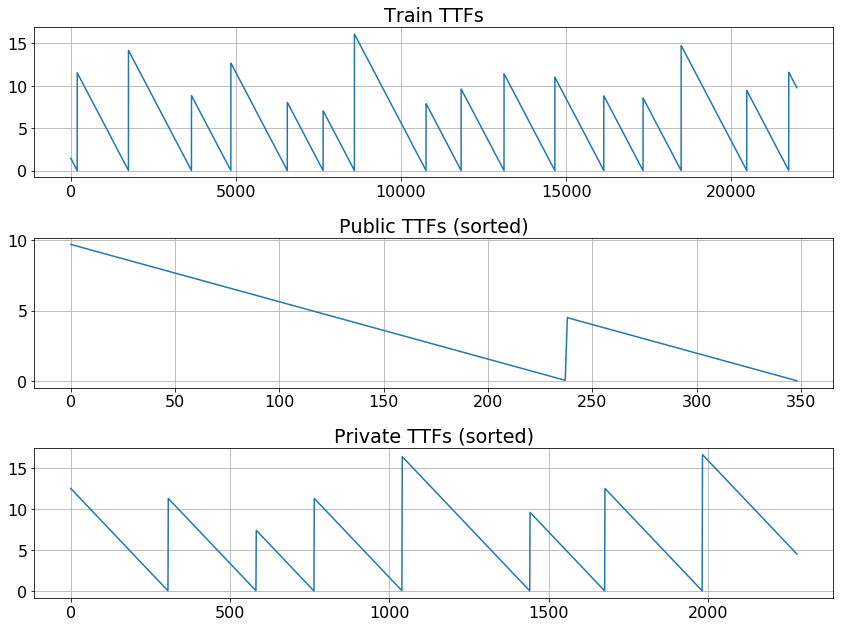

In [12]:
# get ttf distributions
d_train = train_ref

ls_public = (9.72,4.5)
h = np.sum(ls_public) / len(p_public)
d_public = np.concatenate([np.arange(l,0,-h) for l in ls_public])

ls_private = (12.550547, 11.332904,  7.436445, 11.332904, 16.447006,  9.628203, 12.550547, 16.690535-4.5)
offs_private = (0,0,0,0,0,0,0,4.5)
h = np.sum(ls_private) / len(p_private)
d_private = np.concatenate([np.arange(o+l,o,-h) for o,l in zip(offs_private,ls_private)])

_, axs = plt.subplots(3,1, figsize=(12,9))
axs[0].plot(d_train)
axs[0].set_title('Train TTFs')
axs[0].grid()
axs[1].plot(d_public)
axs[1].set_title('Public TTFs (sorted)')
axs[1].grid()
axs[2].plot(d_private)
axs[2].set_title('Private TTFs (sorted)')
axs[2].grid()
plt.tight_layout()

# Predictions Analysis

Contents:
- Models errors
- Predictions distributions
- Relations between models
- Predictions vs. time
- Predictions per bucket

In [13]:
n_models = p_train.shape[1]
models = p_train.columns
models_test = p_test.columns
p_train.shape

(21988, 4)

In [14]:
#stds = ['std' in m for m in models]
estimates = models # [m for m,s in zip(models,stds) if not s]
#stds = [m for m,s in zip(models,stds) if s]
n_est = len(estimates)
#n_std = len(stds)
#(n_est, n_std)

In [15]:
e_train = p_train[estimates].copy()
for m in e_train.columns:
    e_train[m] = p_train[m] - train_ref

e_public = p_public[models_test].copy()
for m in e_public.columns:
    e_public[m] = p_public[m] - public_ref

### Errors Analysis

In [56]:
mae = pd.DataFrame({'model':models_test})
mae['train'] = [(p_train[m]-train_ref).abs().mean() for m in models] + [np.nan]
mae['public'] = [(p_public[m]-public_ref).abs().mean() for m in models_test]

# plt.figure(figsize=(16,4))
# plt.plot(mae.model, mae.train, '.', markersize=15, label='Train')
# plt.plot(mae.model, mae.public, '.', markersize=15, label='Public')
# plt.xticks(rotation=45)
# plt.ylabel('MAE')
# plt.grid()
# plt.legend()

mae

,model,train,public
0,model_00,2.003463,1.433520
1,model_01,2.002604,1.440124
2,model_02,2.015023,1.472212
3,model_03,2.016253,1.335979
4,anton,NaN,1.399106


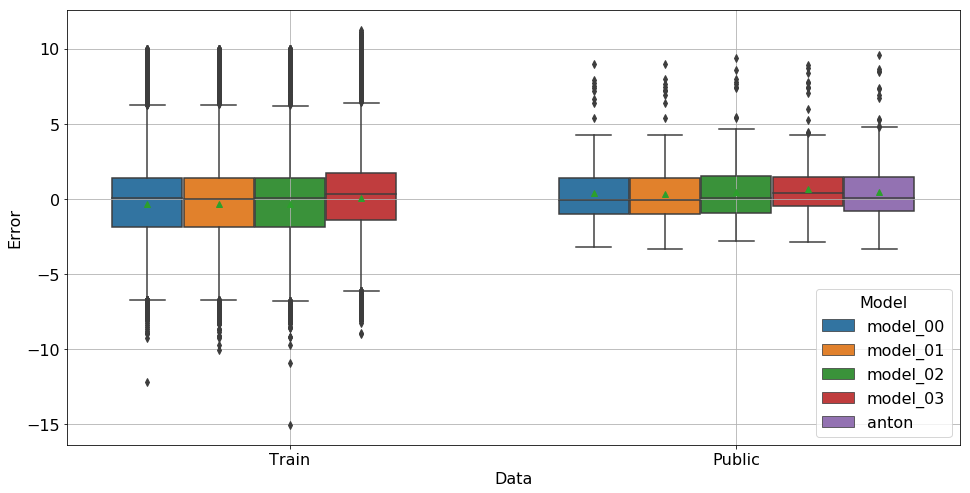

In [17]:
ae = pd.concat([pd.DataFrame({'Error':(e[m]), 'Model':len(e)*[m], 'Data':len(e)*[('Train','Public')[i]]})
                for i,e in enumerate((e_train,e_public)) for m in e.columns])
plt.figure(figsize=(16,8))
sns.boxplot(data=ae, x='Data', y='Error', hue='Model', showmeans=True)
plt.grid()

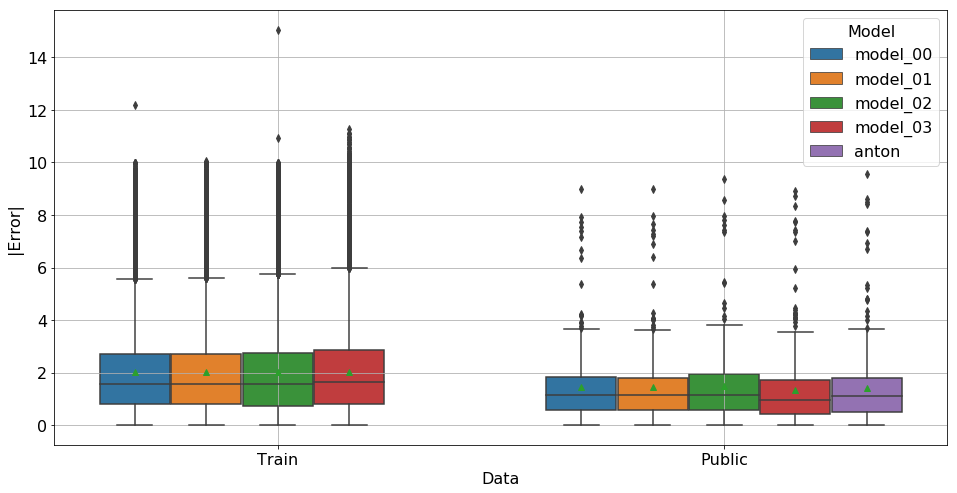

In [57]:
ae = pd.concat([pd.DataFrame({'|Error|':np.abs(e[m]), 'Model':len(e)*[m], 'Data':len(e)*[('Train','Public')[i]]})
                for i,e in enumerate((e_train,e_public)) for m in e.columns])
plt.figure(figsize=(16,8))
sns.boxplot(data=ae, x='Data', y='|Error|', hue='Model', showmeans=True)
plt.grid()

### Mixup with Anton

,alphas,mix0,mix3
0,0.0,1.433520,1.335979
1,0.1,1.422883,1.332203
2,0.2,1.414758,1.331303
3,0.3,1.407459,1.333176
4,0.4,1.401017,1.336587
5,0.5,1.395846,1.341024
6,0.6,1.393934,1.347483
7,0.7,1.393794,1.356235
8,0.8,1.394632,1.368493
9,0.9,1.396151,1.383072


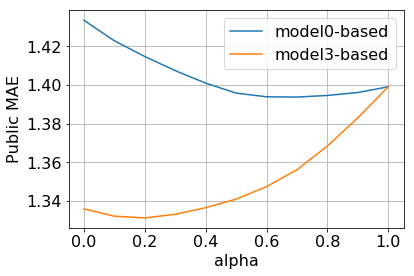

In [80]:
mix = pd.DataFrame({'alphas' : np.arange(0,1.0001,0.1)})

mix['mix0'] = [((1-a)*p_public['model_00']+a*p_public.anton-public_ref).abs().mean() for a in mix.alphas]
mix['mix3'] = [((1-a)*p_public['model_03']+a*p_public.anton-public_ref).abs().mean() for a in mix.alphas]

plt.plot(mix.alphas, mix.mix0, label='model0-based')
plt.plot(mix.alphas, mix.mix3, label='model3-based')
plt.xlabel('alpha')
plt.ylabel('Public MAE')
plt.grid()
plt.legend()

mix

Text(0.5, 1.0, 'Histogram of Private Mix Predictions by Alpha')

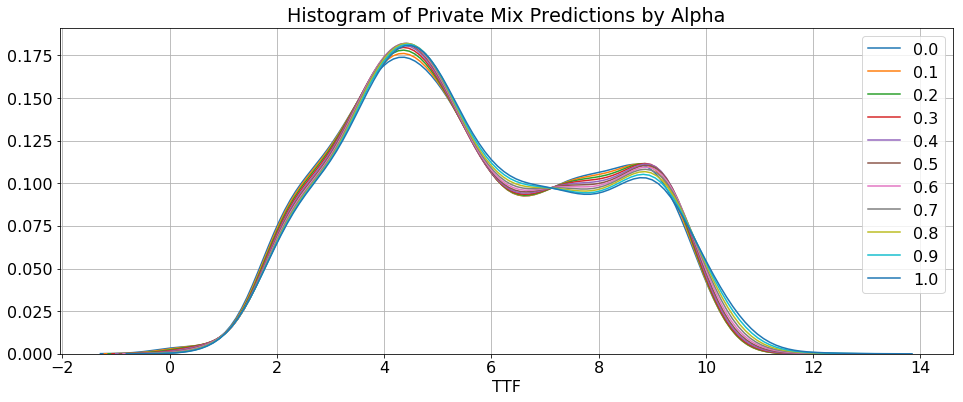

In [87]:
plt.figure(figsize=(16,6))
for a in mix.alphas:
    sns.distplot((1-a)*p_private['model_00']+a*p_private.anton, hist=False, ax=None, label=f'{a:.1f}')
plt.grid()
plt.xlabel('TTF')
plt.title('Histogram of Private Mix Predictions by Alpha')

Text(0.5, 1.0, 'Histogram of Private Mix Predictions by Alpha')

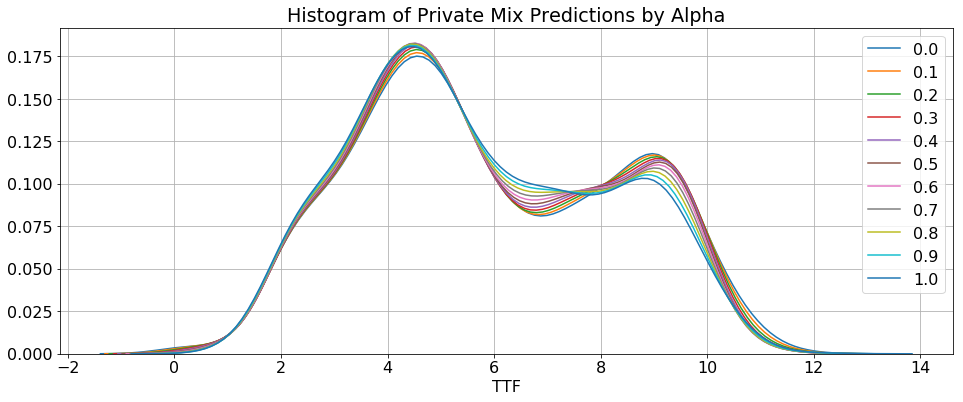

In [88]:
plt.figure(figsize=(16,6))
for a in mix.alphas:
    sns.distplot((1-a)*p_private['model_03']+a*p_private.anton, hist=False, ax=None, label=f'{a:.1f}')
plt.grid()
plt.xlabel('TTF')
plt.title('Histogram of Private Mix Predictions by Alpha')

### Predictions Distributions

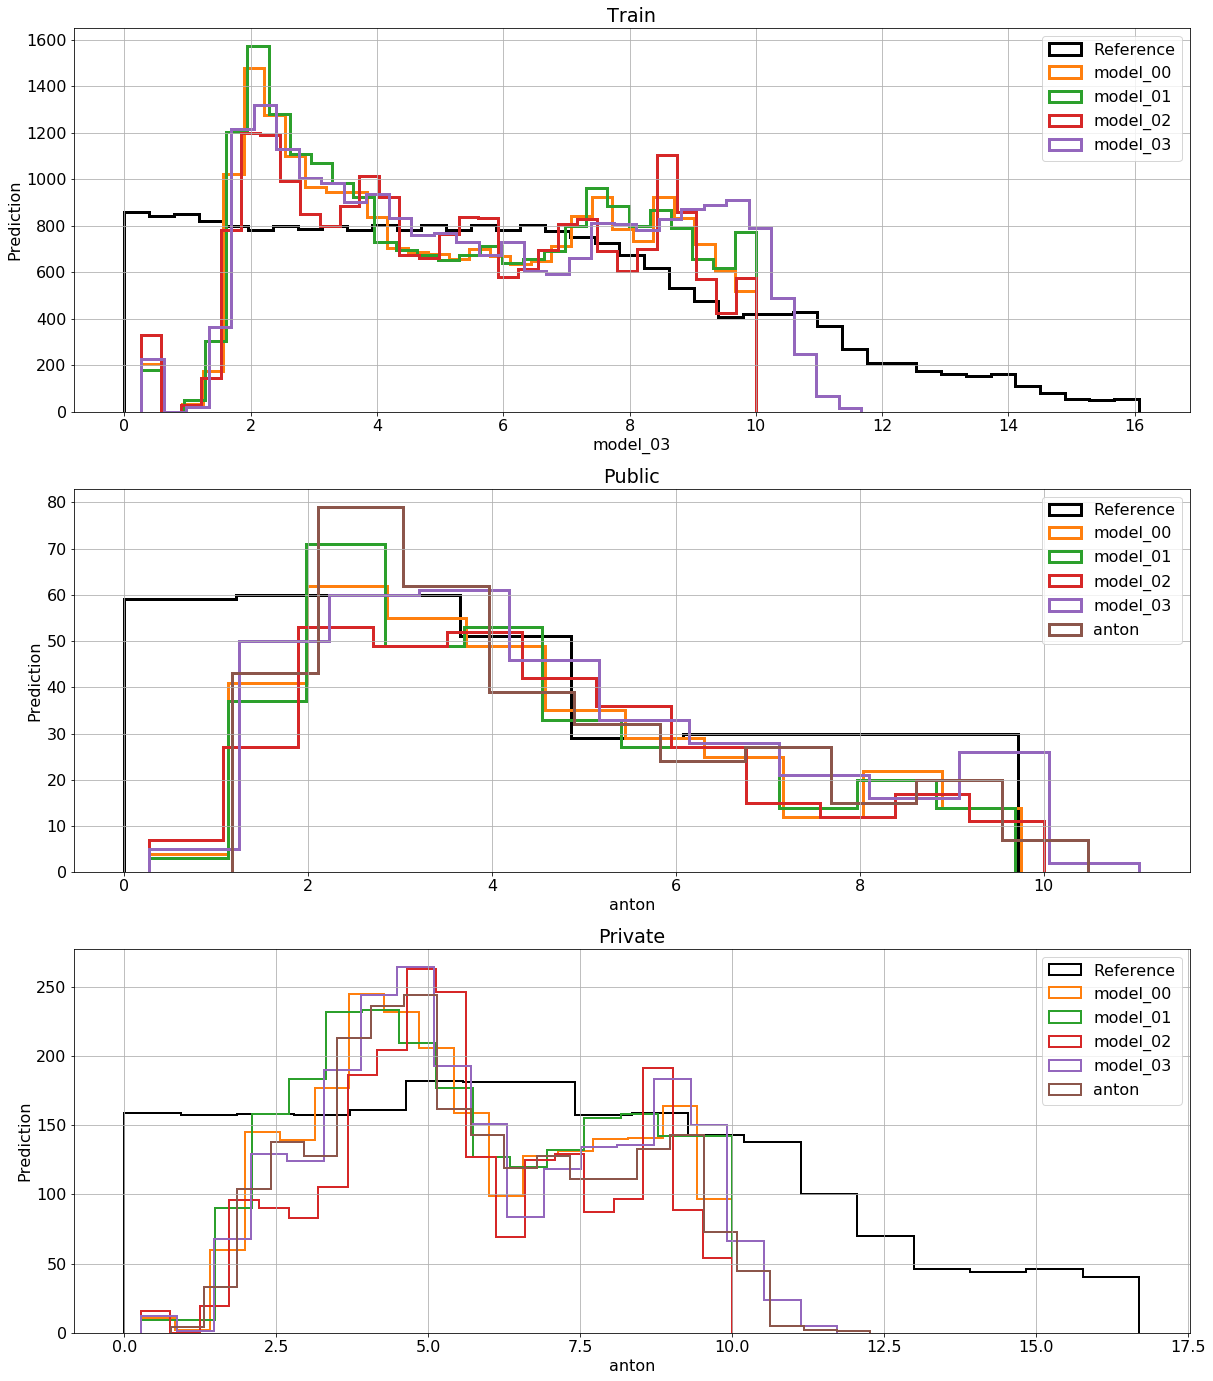

In [66]:
fig, axs = plt.subplots(3,1, figsize=(20,24))

ax = axs[0]
sns.distplot(d_train, kde=False, hist_kws={"histtype": "step", "linewidth": 2, "alpha": 1, 'color':'k'},
             ax=ax, label='Reference')
for est in models:
    sns.distplot(p_train[est], kde=False, hist_kws={"histtype": "step", "linewidth": 2, "alpha": 1}, ax=ax, label=est)
ax.grid()
ax.set_title('Train')
ax.set_ylabel('Prediction')
ax.legend()

ax = axs[1]
sns.distplot(d_public, kde=False, hist_kws={"histtype": "step", "linewidth": 2, "alpha": 1, 'color':'k'},
             ax=ax, label='Reference')
for est in models_test:
    sns.distplot(p_public[est], kde=False, hist_kws={"histtype": "step", "linewidth": 2, "alpha": 1},
                 ax=ax, label=est)
ax.grid()
ax.set_title('Public')
ax.set_ylabel('Prediction')
ax.legend()

ax = axs[2]
sns.distplot(d_private, kde=False, hist_kws={"histtype": "step", "linewidth": 2, "alpha": 1, 'color':'k'},
             ax=ax, label='Reference')
for est in models_test:
    sns.distplot(p_private[est], kde=False, hist_kws={"histtype": "step", "linewidth": 2, "alpha": 1},
                 ax=ax, label=est)
ax.grid()
ax.set_title('Private')
ax.set_ylabel('Prediction')
ax.legend()

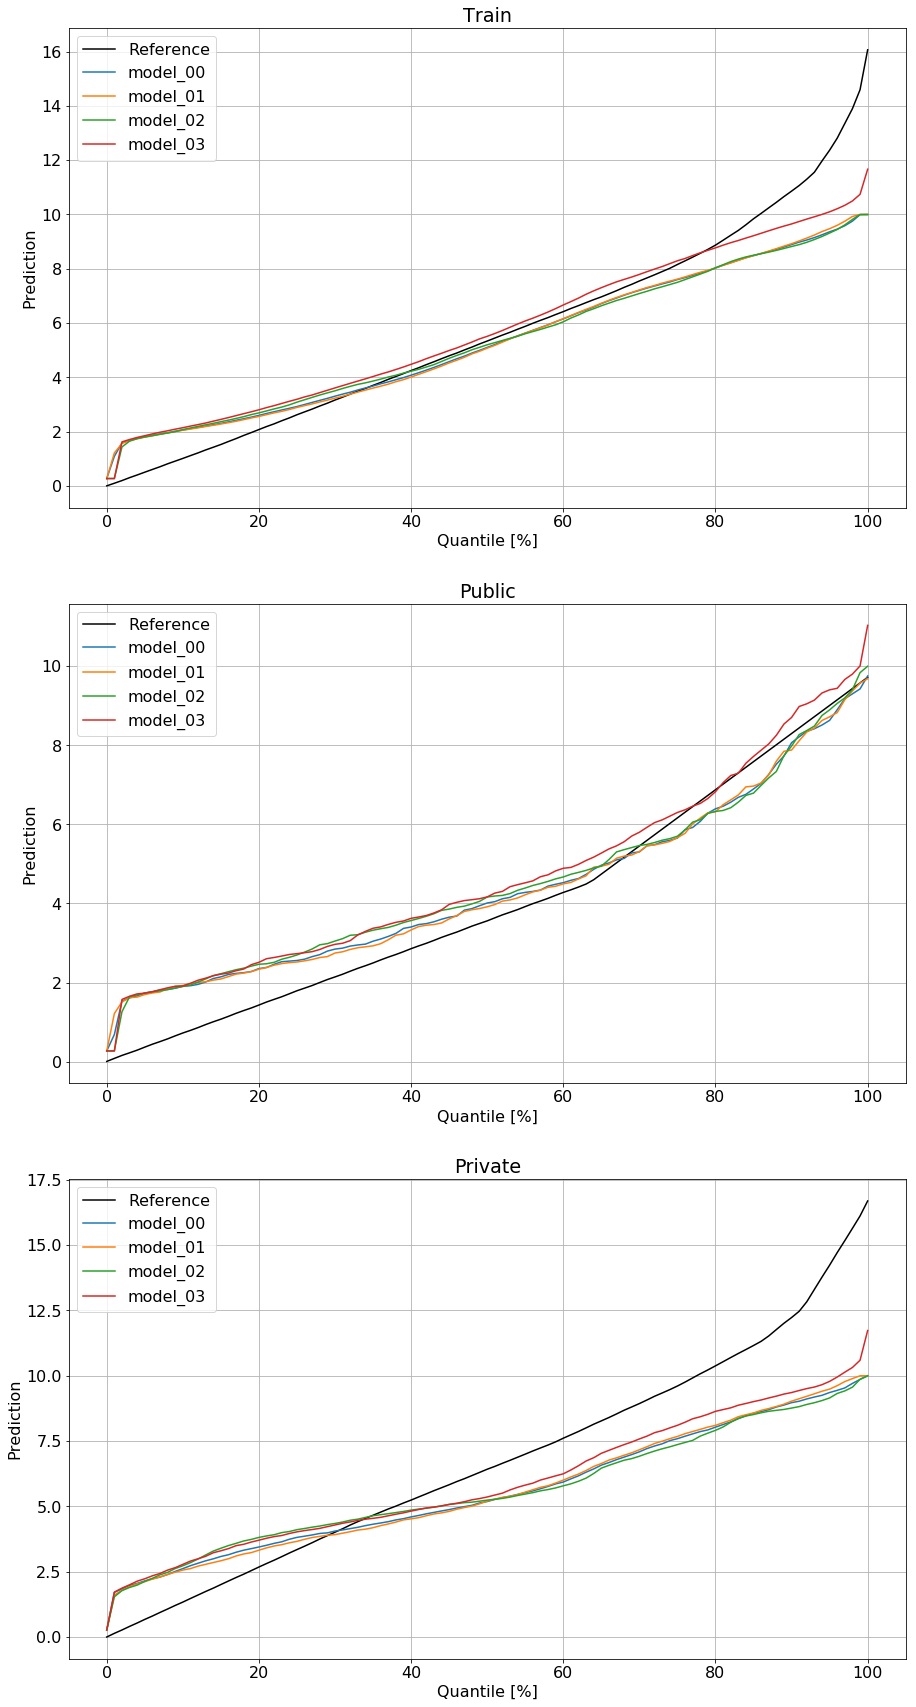

In [20]:
_, axs = plt.subplots(3,1, figsize=(15,30))

ax = axs[0]
ax.plot(list(range(101)), np.quantile(d_train, np.arange(0,1.0001,1/100)), color='k', label='Reference')
for m in models:
    ax.plot(list(range(101)), np.quantile(p_train[m], np.arange(0,1.0001,1/100)), label=m)
ax.set_title('Train')
ax.set_xlabel('Quantile [%]')
ax.set_ylabel('Prediction')
ax.grid()
ax.legend()

ax = axs[1]
ax.plot(list(range(101)), np.quantile(d_public, np.arange(0,1.0001,1/100)), color='k', label='Reference')
for m in models_test:
    ax.plot(list(range(101)), np.quantile(p_public[m], np.arange(0,1.0001,1/100)), label=m)
ax.set_title('Public')
ax.set_xlabel('Quantile [%]')
ax.set_ylabel('Prediction')
ax.grid()
ax.legend()

ax = axs[2]
ax.plot(list(range(101)), np.quantile(d_private, np.arange(0,1.0001,1/100)), color='k', label='Reference')
for m in models_test:
    ax.plot(list(range(101)), np.quantile(p_private[m], np.arange(0,1.0001,1/100)), label=m)
ax.set_title('Private')
ax.set_xlabel('Quantile [%]')
ax.set_ylabel('Prediction')
ax.grid()
ax.legend()



In [21]:
# compute distance between distributions model_preds & true_ttfs.
# L1-norm between hists doesn't consider close vs. far buckets, thus not so good.
# E[|pred-true|] for random sampling may be good.
# look for distance between distributions, e.g.
# https://en.wikipedia.org/wiki/Statistical_distance

def dist_dist(p, p0, n=int(1e6)): # distributions distance
    return np.abs(np.random.choice(p,n)-np.random.choice(p0,n)).mean()

def dists_dists(preds, p0, n=int(1e6)):
    return [dist_dist(preds[p],p0,n) for p in preds.columns]

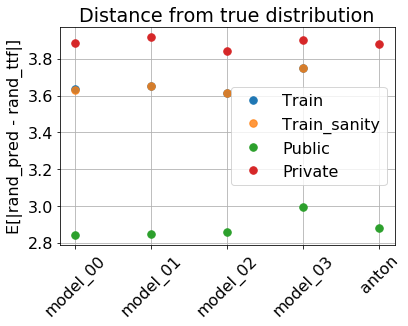

In [24]:
plt.figure(figsize=(6,4))
plt.plot(models, dists_dists(p_train, d_train), '.', markersize=15, label='Train')
plt.plot(models, dists_dists(p_train, d_train), '.', markersize=15, label='Train_sanity', alpha=0.8)
plt.plot(models_test, dists_dists(p_public, d_public), '.', markersize=15, label='Public')
plt.plot(models_test, dists_dists(p_private, d_private), '.', markersize=15, label='Private')
plt.title('Distance from true distribution')
plt.ylabel('E[|rand_pred - rand_ttf|]')
plt.xticks(rotation=45)
plt.grid()
plt.legend()

,E[|rand_pred - rand_ttf|],Model,Data
0,3.635687,model_00,Train
0,3.646780,model_01,Train
0,3.616783,model_02,Train
0,3.755643,model_03,Train
0,2.846510,model_00,Public
0,2.846147,model_01,Public
0,2.863194,model_02,Public
0,2.990834,model_03,Public
0,2.878577,anton,Public
0,3.893063,model_00,Private


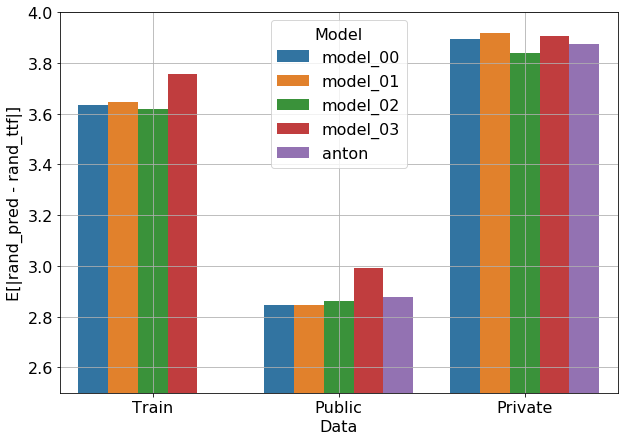

In [45]:
dd = pd.concat([pd.DataFrame(
    {'E[|rand_pred - rand_ttf|]':dist_dist(p[m],p0), 'Model':m, 'Data':('Train','Public','Private')[i]}, index=[0])
                for i,(p,p0) in enumerate(zip((p_train,p_public,p_private),(d_train,d_public,d_private))) for m in p.columns])
plt.figure(figsize=(10,7))
sns.barplot(data=dd, x='Data', hue='Model', y='E[|rand_pred - rand_ttf|]')
plt.ylim((2.5,4))
plt.grid()

dd

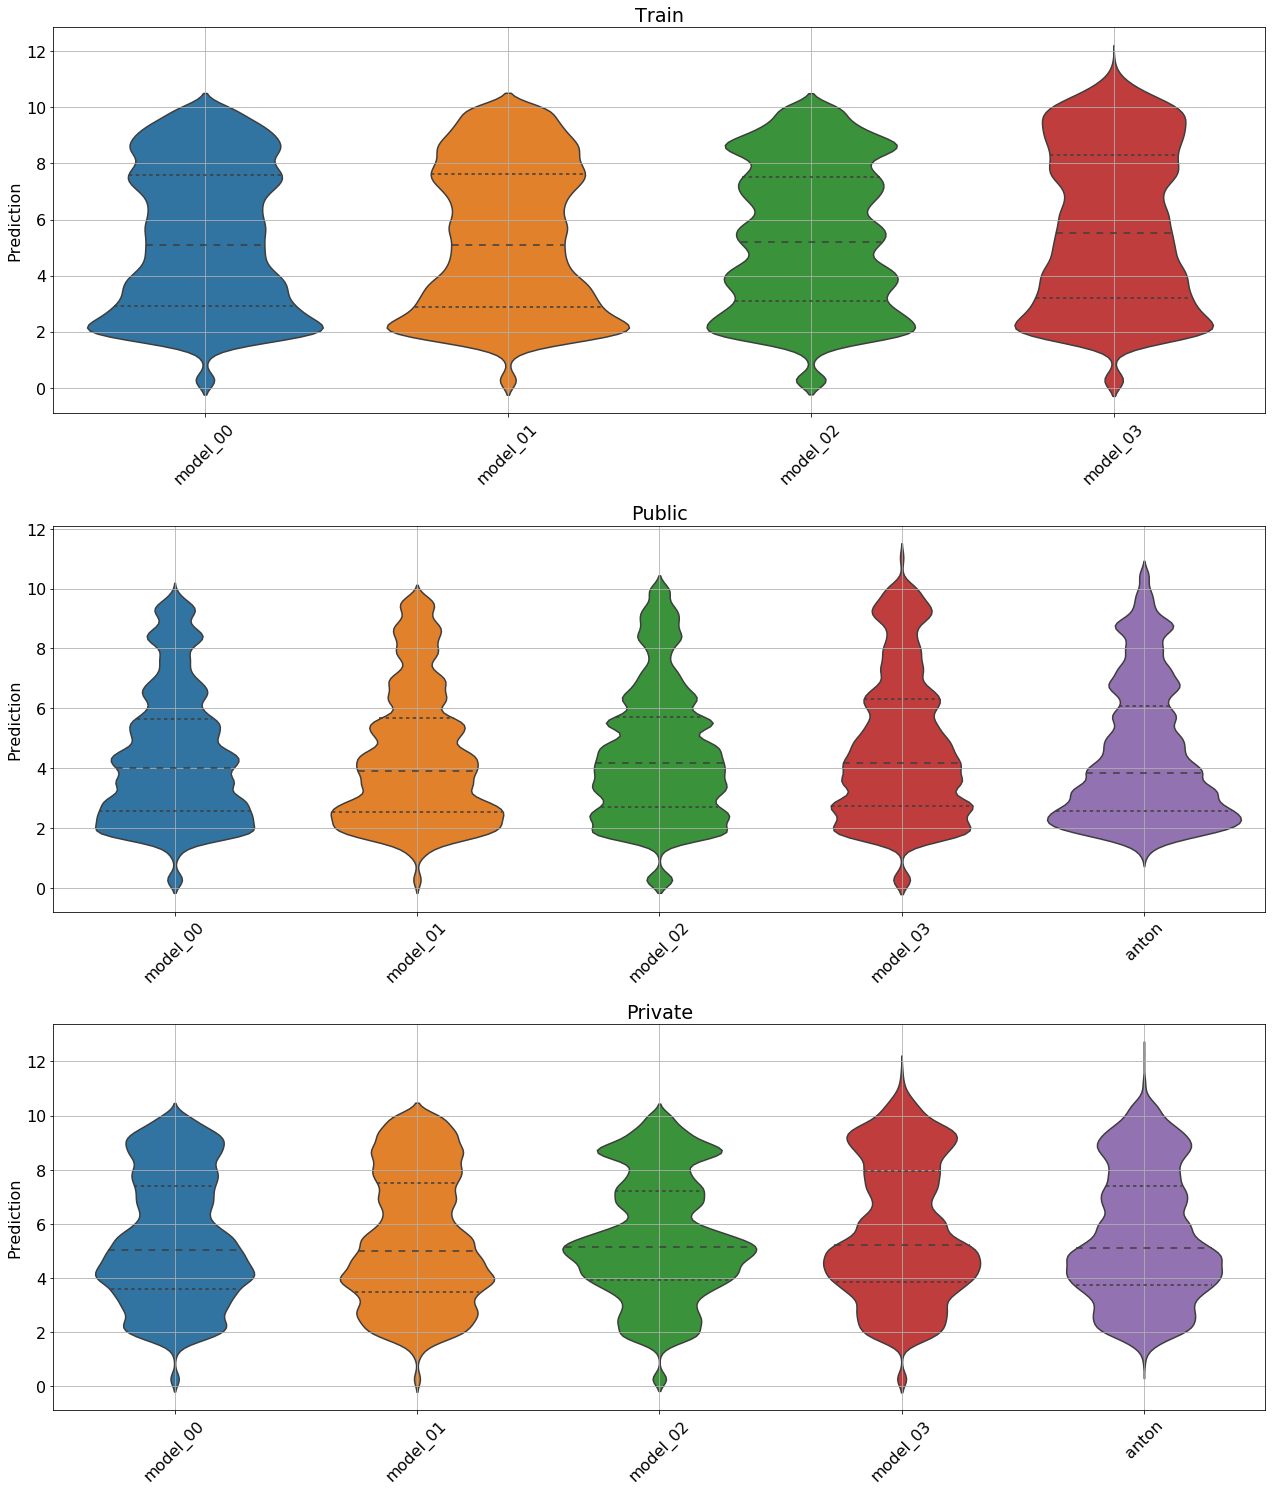

In [67]:
_, axs = plt.subplots(3,1, figsize=(18,21))

for i, preds in enumerate((p_train,p_public,p_test)):
    ax = axs[i]
    sns.violinplot(data=preds, inner='quart', ax=ax, bw=0.1)
    ax.grid()
    ax.set_title(('Train','Public','Private')[i])
    ax.set_ylabel('Prediction')
    for tick in ax.get_xticklabels(): tick.set_rotation(45)
        
plt.tight_layout()

### Relations between Models

In [75]:
# relations between predictions
def mi_vs_mj(preds):
    fig, axs = plt.subplots(len(preds.columns),len(preds.columns), figsize=(16,16))
    for i,m1 in enumerate(preds.columns):
        for j,m2 in enumerate(preds.columns):
            ax = axs[i,j]
            ax.plot(preds[m1],preds[m2],',')
            if i == len(preds.columns)-1:
                ax.set_xlabel(m2, rotation=45)
            if j == 0:
                ax.set_ylabel(m1, rotation=45)
    #plt.tight_layout()

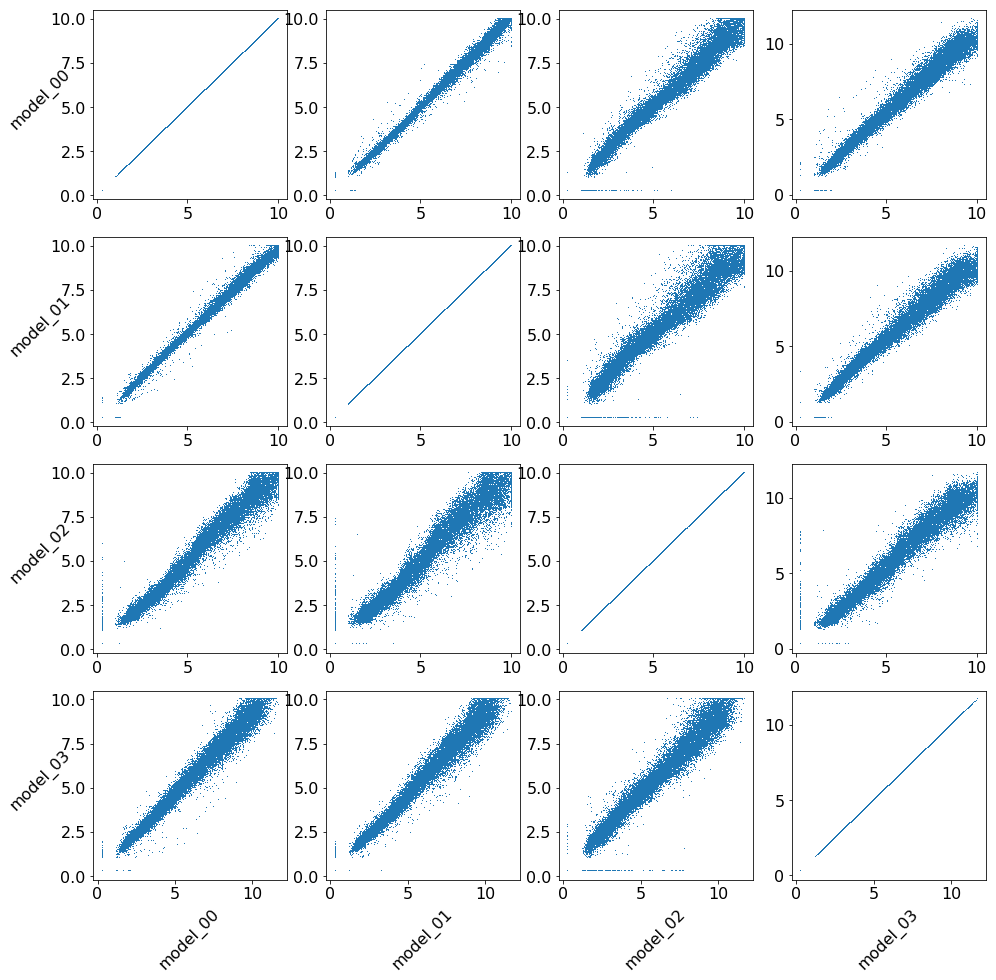

In [69]:
mi_vs_mj(p_train)

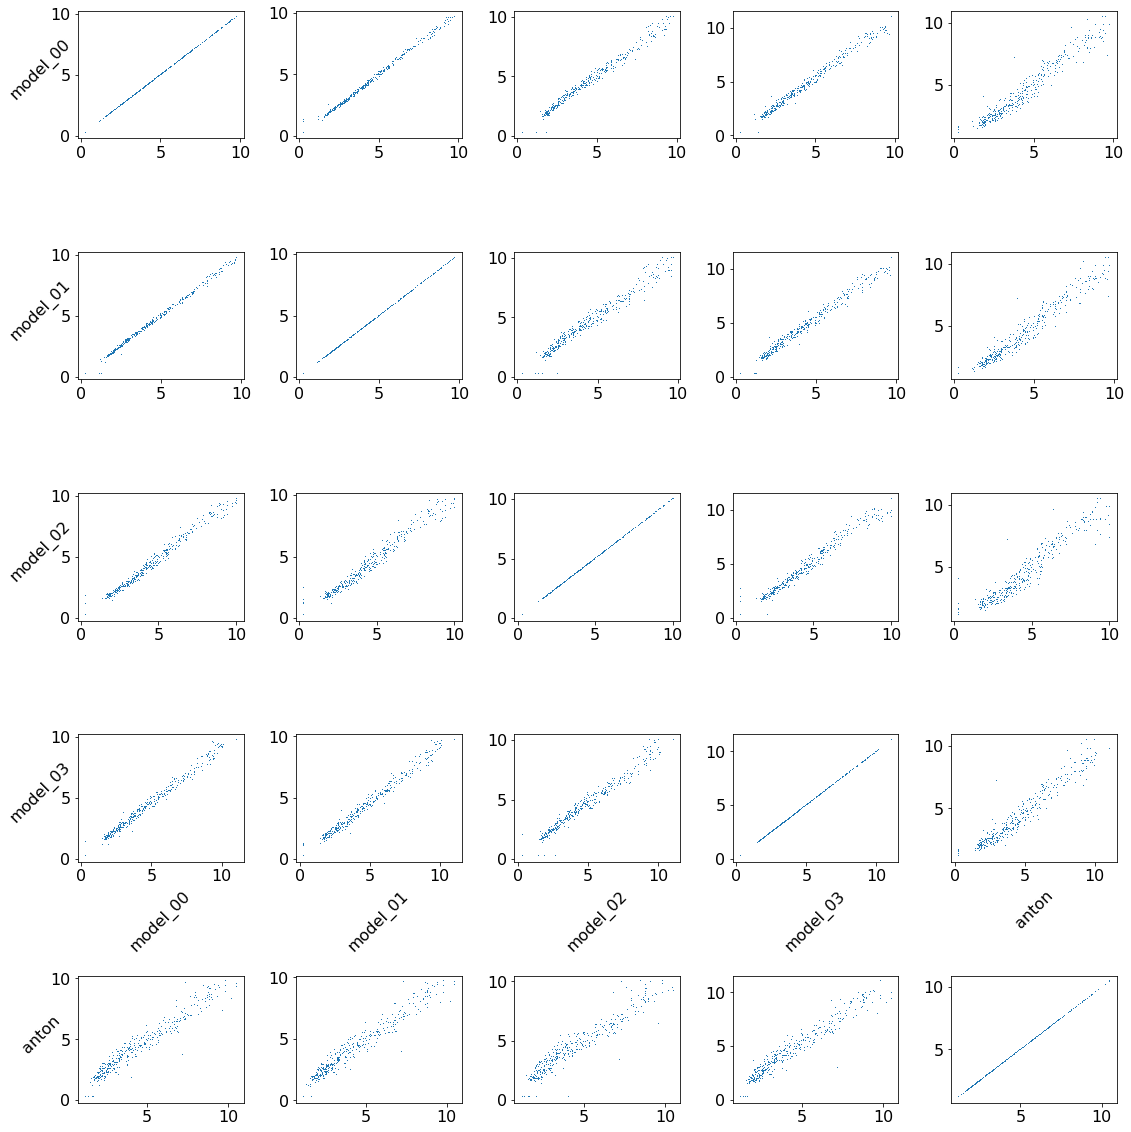

In [74]:
mi_vs_mj(p_public)

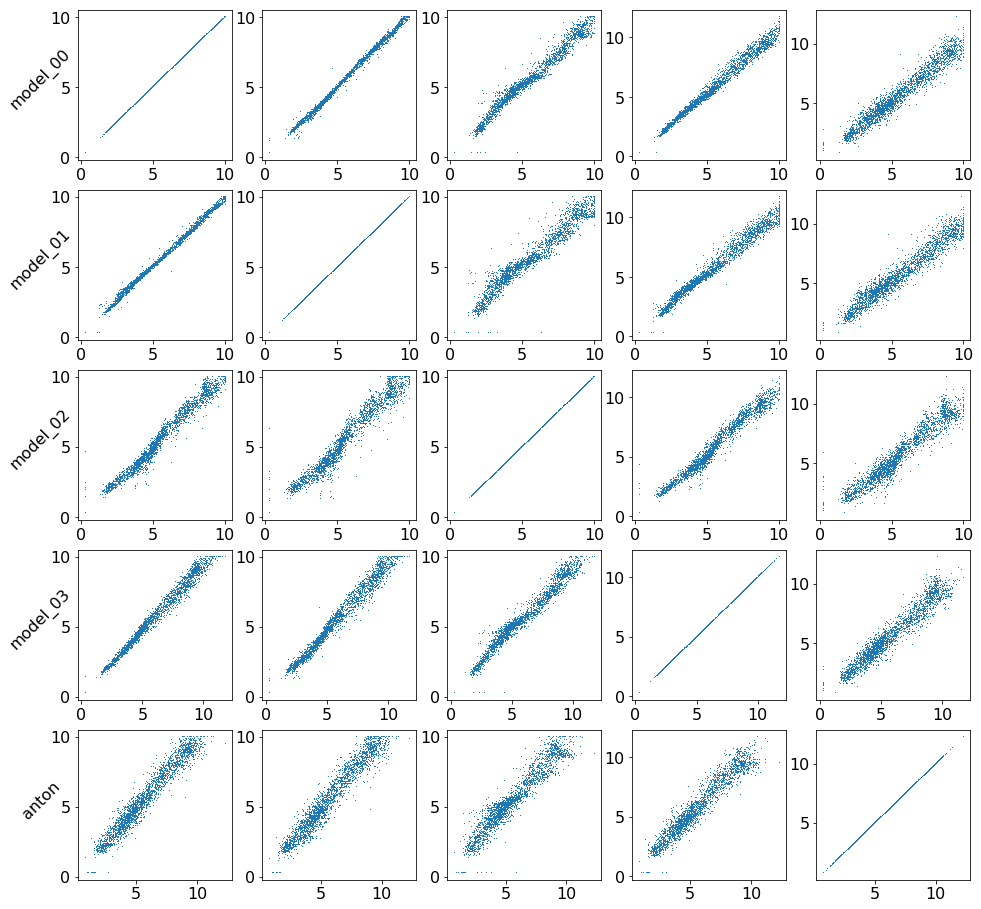

In [73]:
mi_vs_mj(p_private)

In [76]:
def preds_affinity(preds, ax, corr, data):
    sns.heatmap(
        pd.DataFrame(100*np.array([[np.corrcoef(preds[m1],preds[m2])[0,1] if corr else (preds[m1]-preds[m2]).abs().mean()
                                    for m2 in preds.columns] for m1 in preds.columns]),
                     columns=preds.columns, index=preds.columns),
        annot=True, fmt='.0f', cmap='Reds', ax=ax
    )
    ax.set_title(f'{data:s}: Correlation [x100]' if corr else f'{data:s}: L1-distance [x100]')

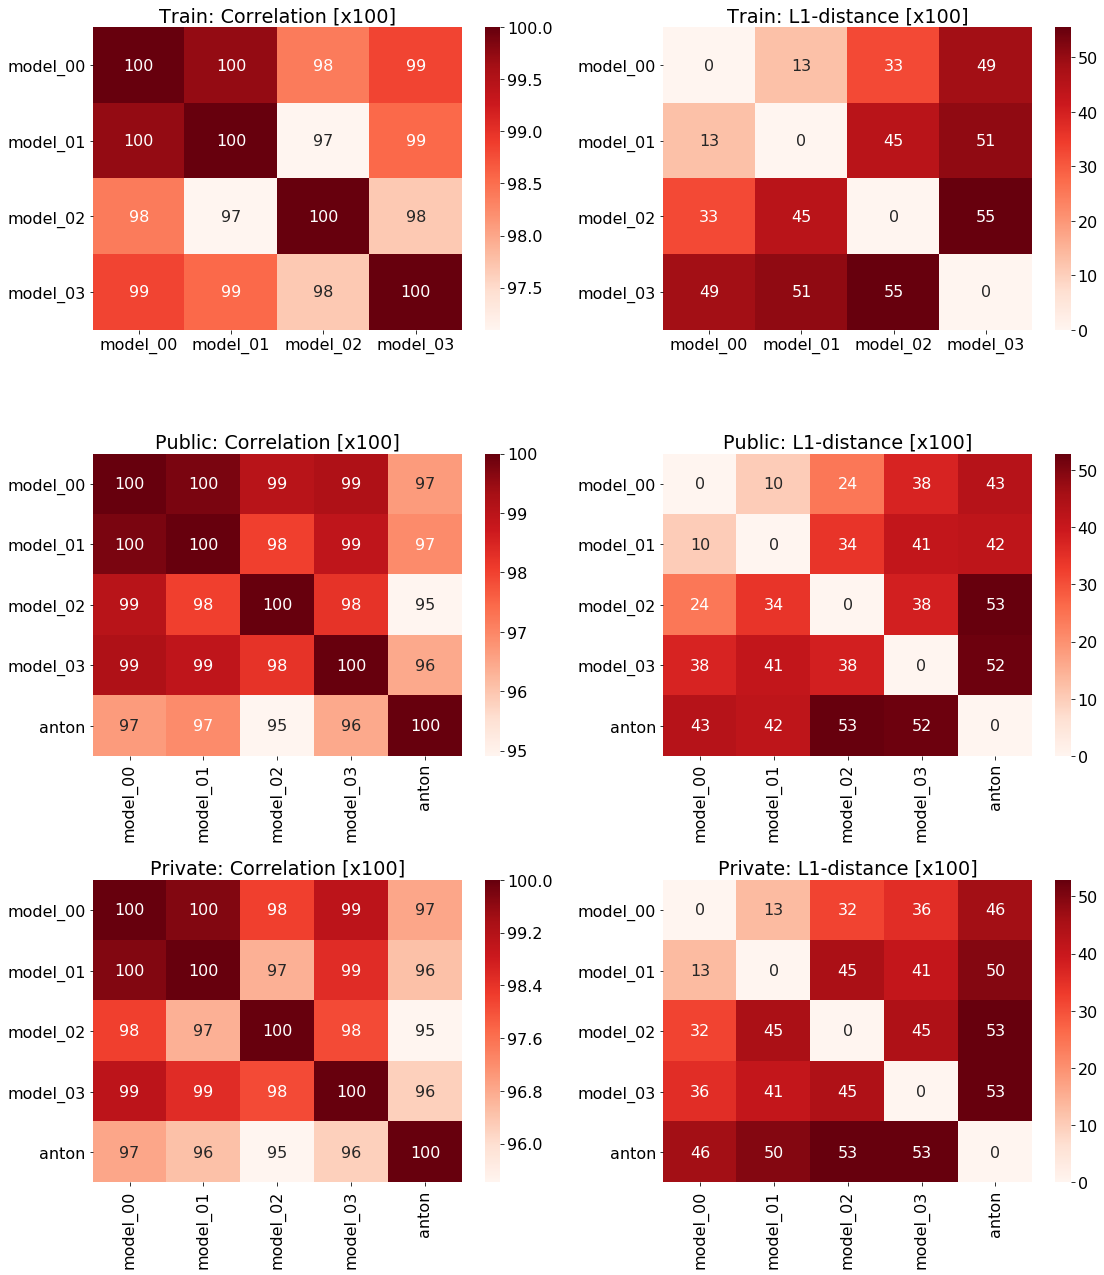

In [77]:
fig, axs = plt.subplots(3,2, figsize=(16,18))
for i in range(6):
    preds_affinity((p_train,p_public,p_private)[i//2], axs[i//2, i%2], i%2==0, ('Train','Public','Private')[i//2])
plt.tight_layout()

In [33]:
# fig, axs = plt.subplots(n_std,n_std, figsize=(9,9))
# for i,m1 in enumerate(stds):
#     for j,m2 in enumerate(stds):
#         ax = axs[i,j]
#         ax.plot(preds[m1],preds[m2],',')
#         ax.grid()
#         if i == n_std-1:
#             ax.set_xlabel(m2)
#         if j == 0:
#             ax.set_ylabel(m1)

### Predictions vs. Time

In [34]:
quake_starts = np.where(np.diff(train_ref)>0)[0] + 1
def plot_quakes(ax, full=False):
    for qs in quake_starts:
        ax.axvline(qs, linestyle='--', color='red')
    if full:
        ax.plot(train_ref, 'r-', linewidth=1, label='True TTF')
    ax.set_xlim((0,n_train))
    ax.set_xlabel('segment')
    ax.grid()

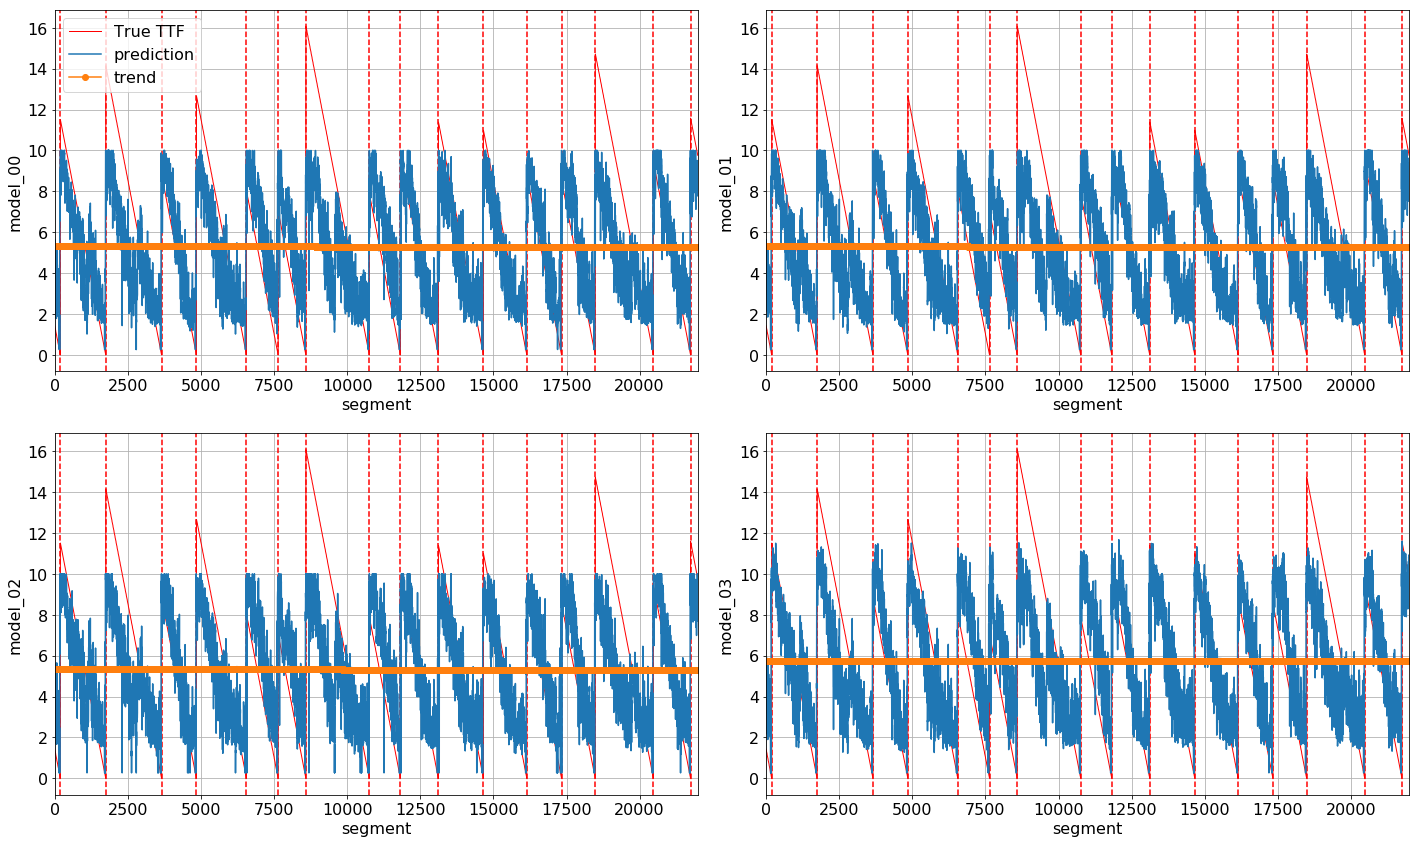

In [35]:
# predictions over time
fig, axs = plt.subplots(int(np.ceil(n_models/2)),2, figsize=(20,3*n_models))
segs = list(range(n_train))
for i,m in enumerate(estimates):
    ax = axs[i//2, i%2]
    plot_quakes(ax, True)
    ax.plot(p_train[m], label='prediction')
    z = np.polyfit(segs, p_train[m], 1)
    p = np.poly1d(z)
    ax.plot(segs,p(segs),"o-", label='trend')
    ax.set_ylabel(m)
    if i==0:
        ax.legend()
plt.tight_layout()

In [36]:
# fig, axs = plt.subplots(2,2, figsize=(20,14))
# for i,m in enumerate(stds):
#     ax = axs[i//2, i%2]
#     ax.plot(preds[m], label='prediction std')
#     plot_quakes(ax)#, True)
#     z = np.polyfit(segs, preds[m], 1)
#     p = np.poly1d(z)
#     ax.plot(segs,p(segs),"o-", label='trend')
#     ax.set_ylabel(m)
#     if i==0:
#         ax.legend()
#     ax.set_ylim((0,2.6))
# plt.tight_layout()

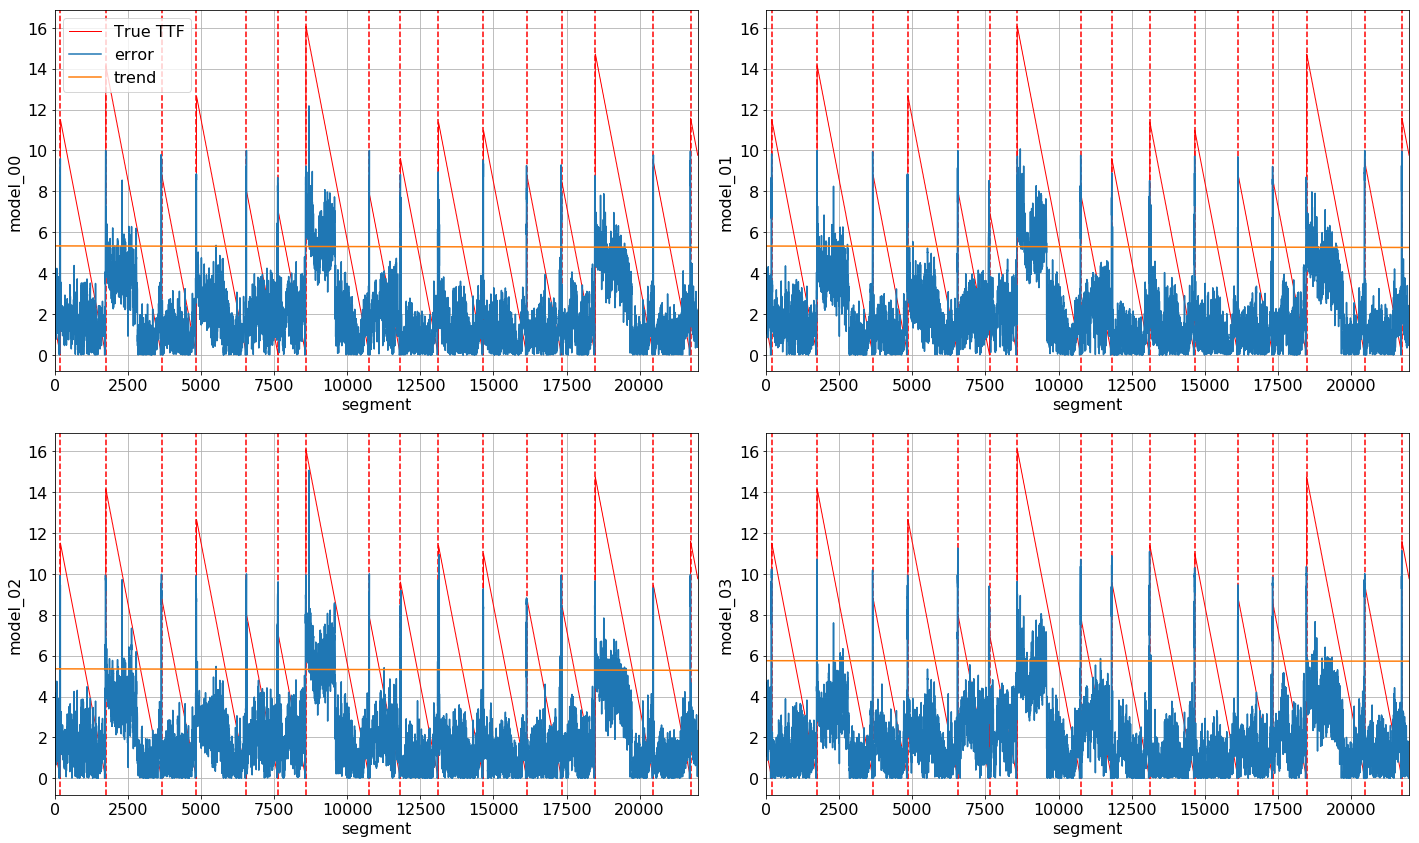

In [37]:
# errors over time
fig, axs = plt.subplots(int(np.ceil(n_models/2)),2, figsize=(20,3*n_models))
segs = list(range(n_train))
for i,m in enumerate(estimates):
    ax = axs[i//2, i%2]
    plot_quakes(ax, True)
    ax.plot(np.abs(p_train[m]-meta.qt), label='error')
    z = np.polyfit(segs, p_train[m], 1)
    p = np.poly1d(z)
    ax.plot(segs, p(segs), markersize=1, label='trend')
    ax.set_ylabel(m)
    if i==0:
        ax.legend()
plt.tight_layout()

### Predictions per Bucket (train data only)

In [38]:
preds = p_train

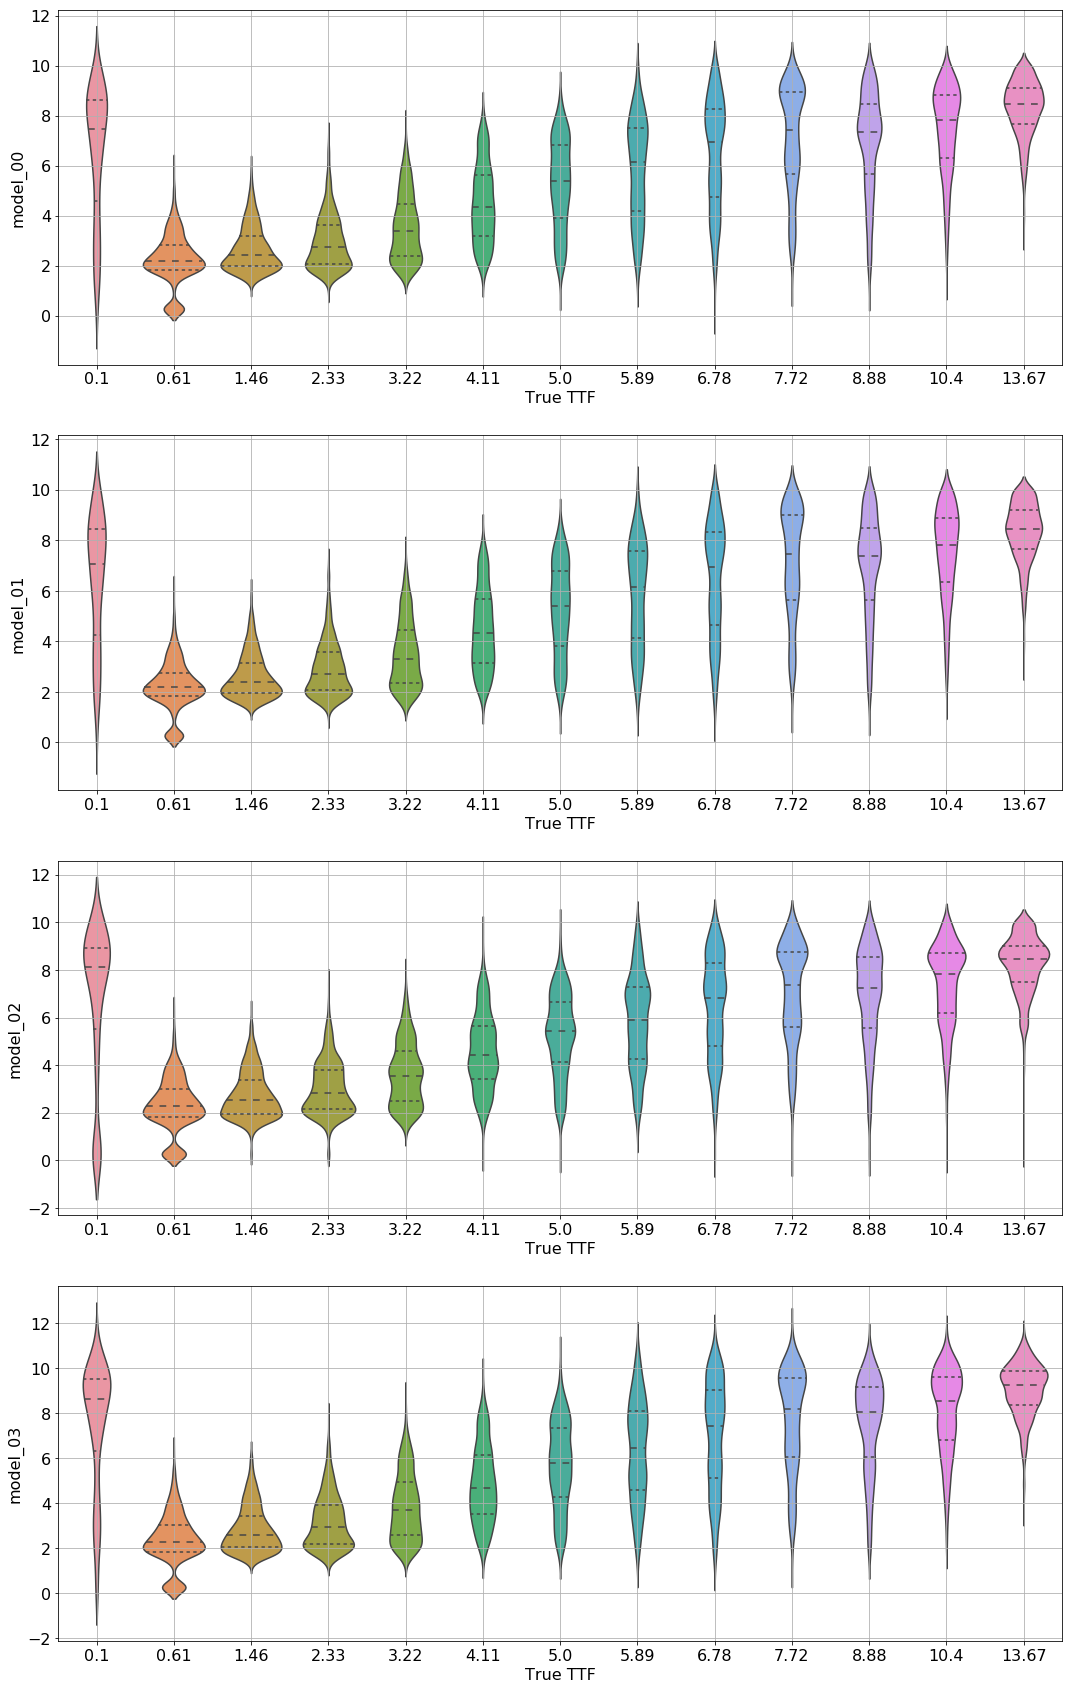

In [39]:
fig, axs = plt.subplots(n_est,1, figsize=(18,30))

for i,m in enumerate(estimates):
    ax = axs[i]
    sns.violinplot(data=pd.DataFrame({'True TTF':round(meta.qt_class_cent,2),m:preds[m]}), x='True TTF', y=m,
                   ax=ax, inner='quart')
    ax.grid()

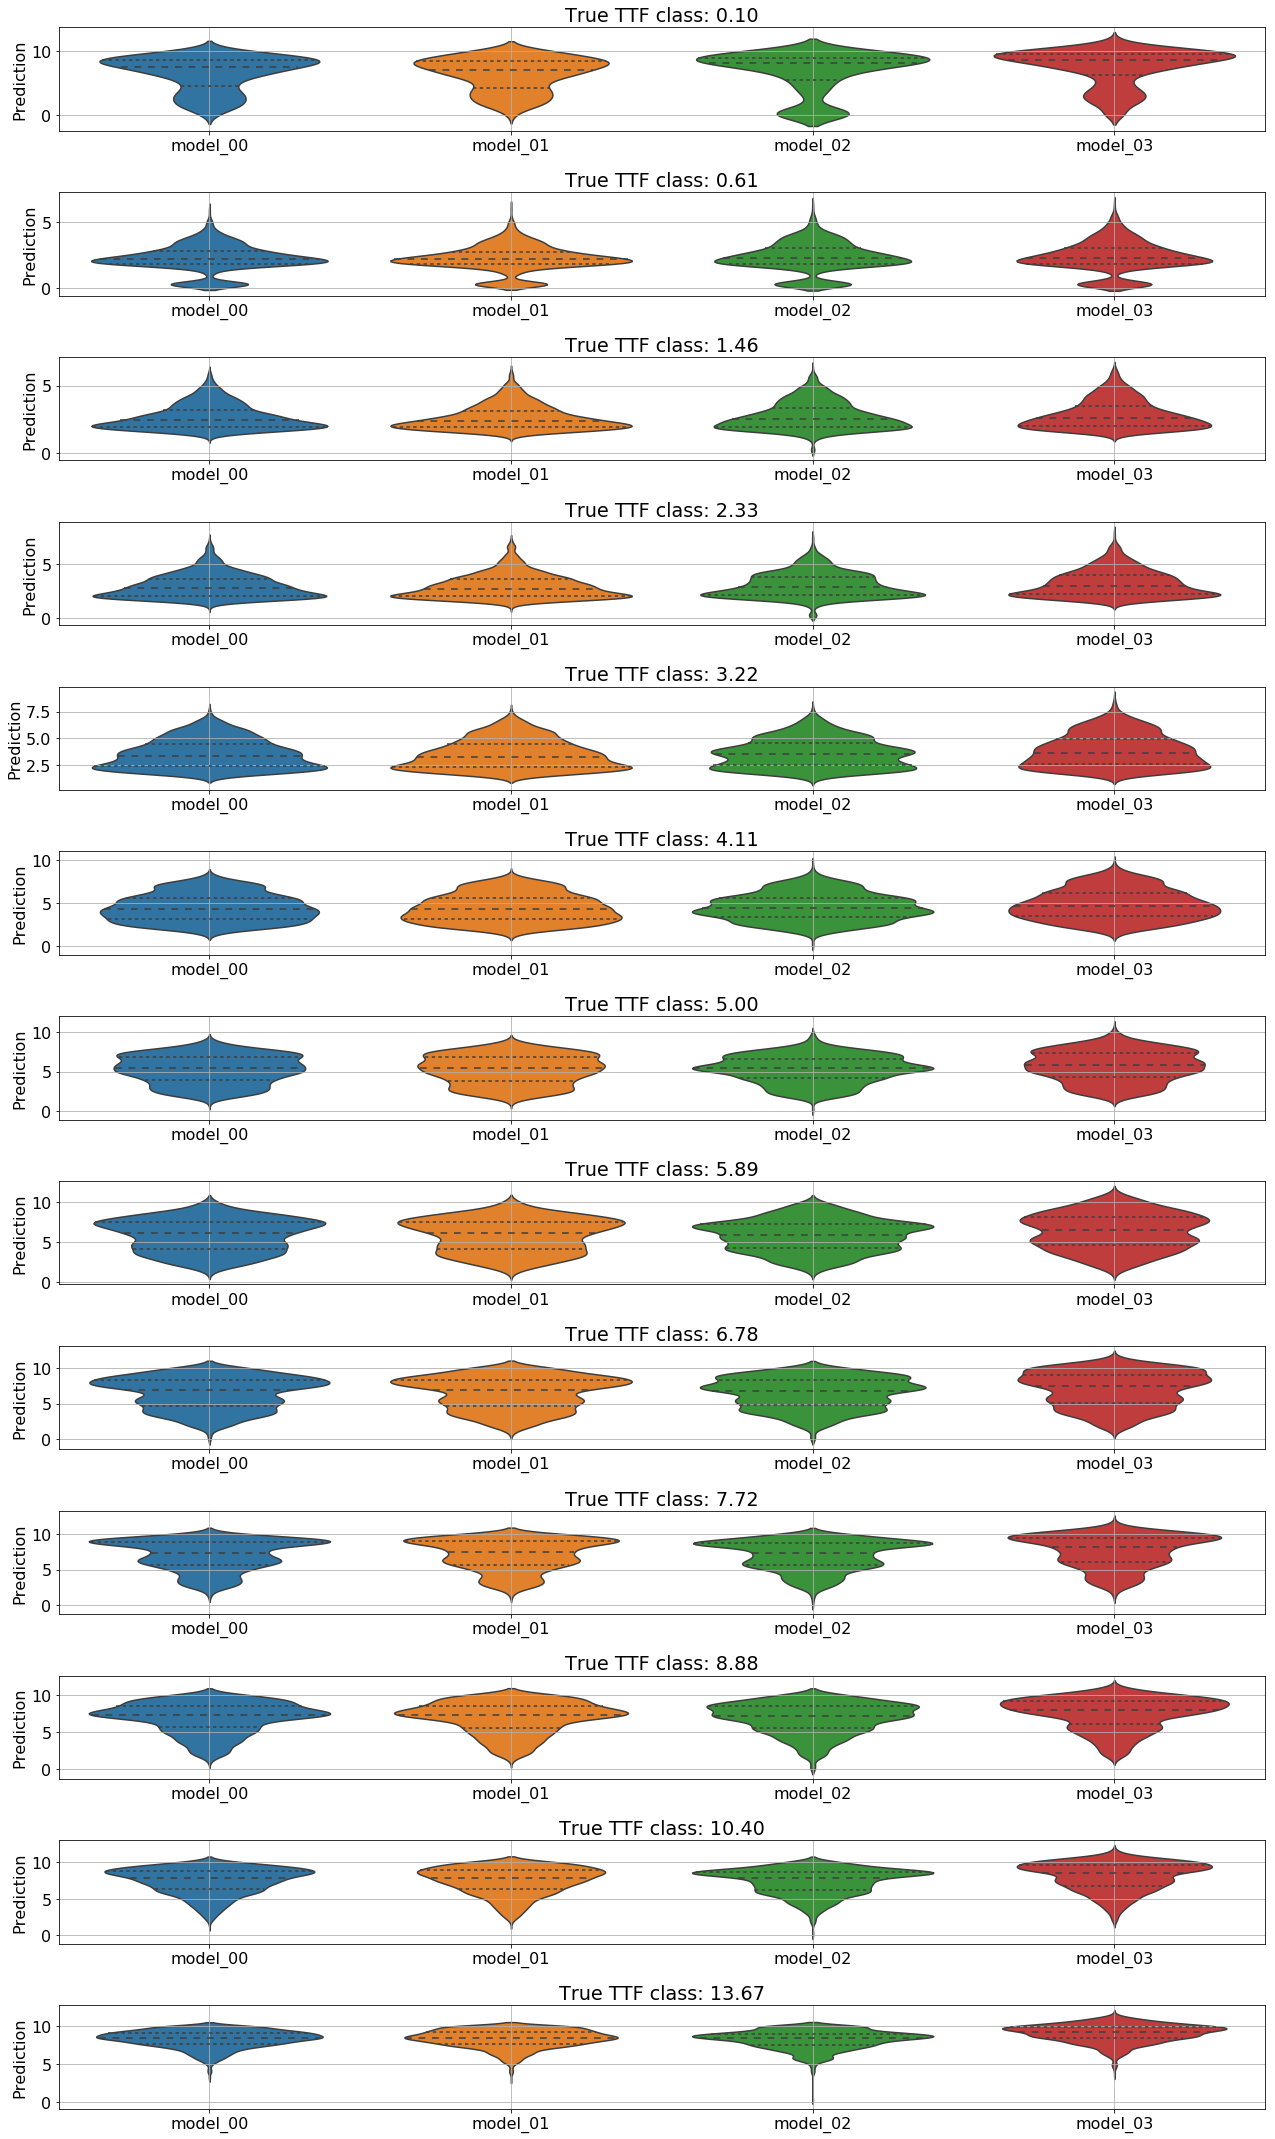

In [40]:
class_cents = np.unique(round(meta.qt_class_cent,2))
fig, axs = plt.subplots(len(class_cents),1, figsize=(18,30))

for i,c in enumerate(class_cents):
    ax = axs[i]
    sns.violinplot(data=pd.DataFrame({m: preds[m][round(meta.qt_class_cent,2)==c] for m in estimates}), ax=ax, inner='quart')
    ax.set_title(f'True TTF class: {c:.2f}')
    ax.set_ylabel('Prediction')
    ax.grid()
    
plt.tight_layout()

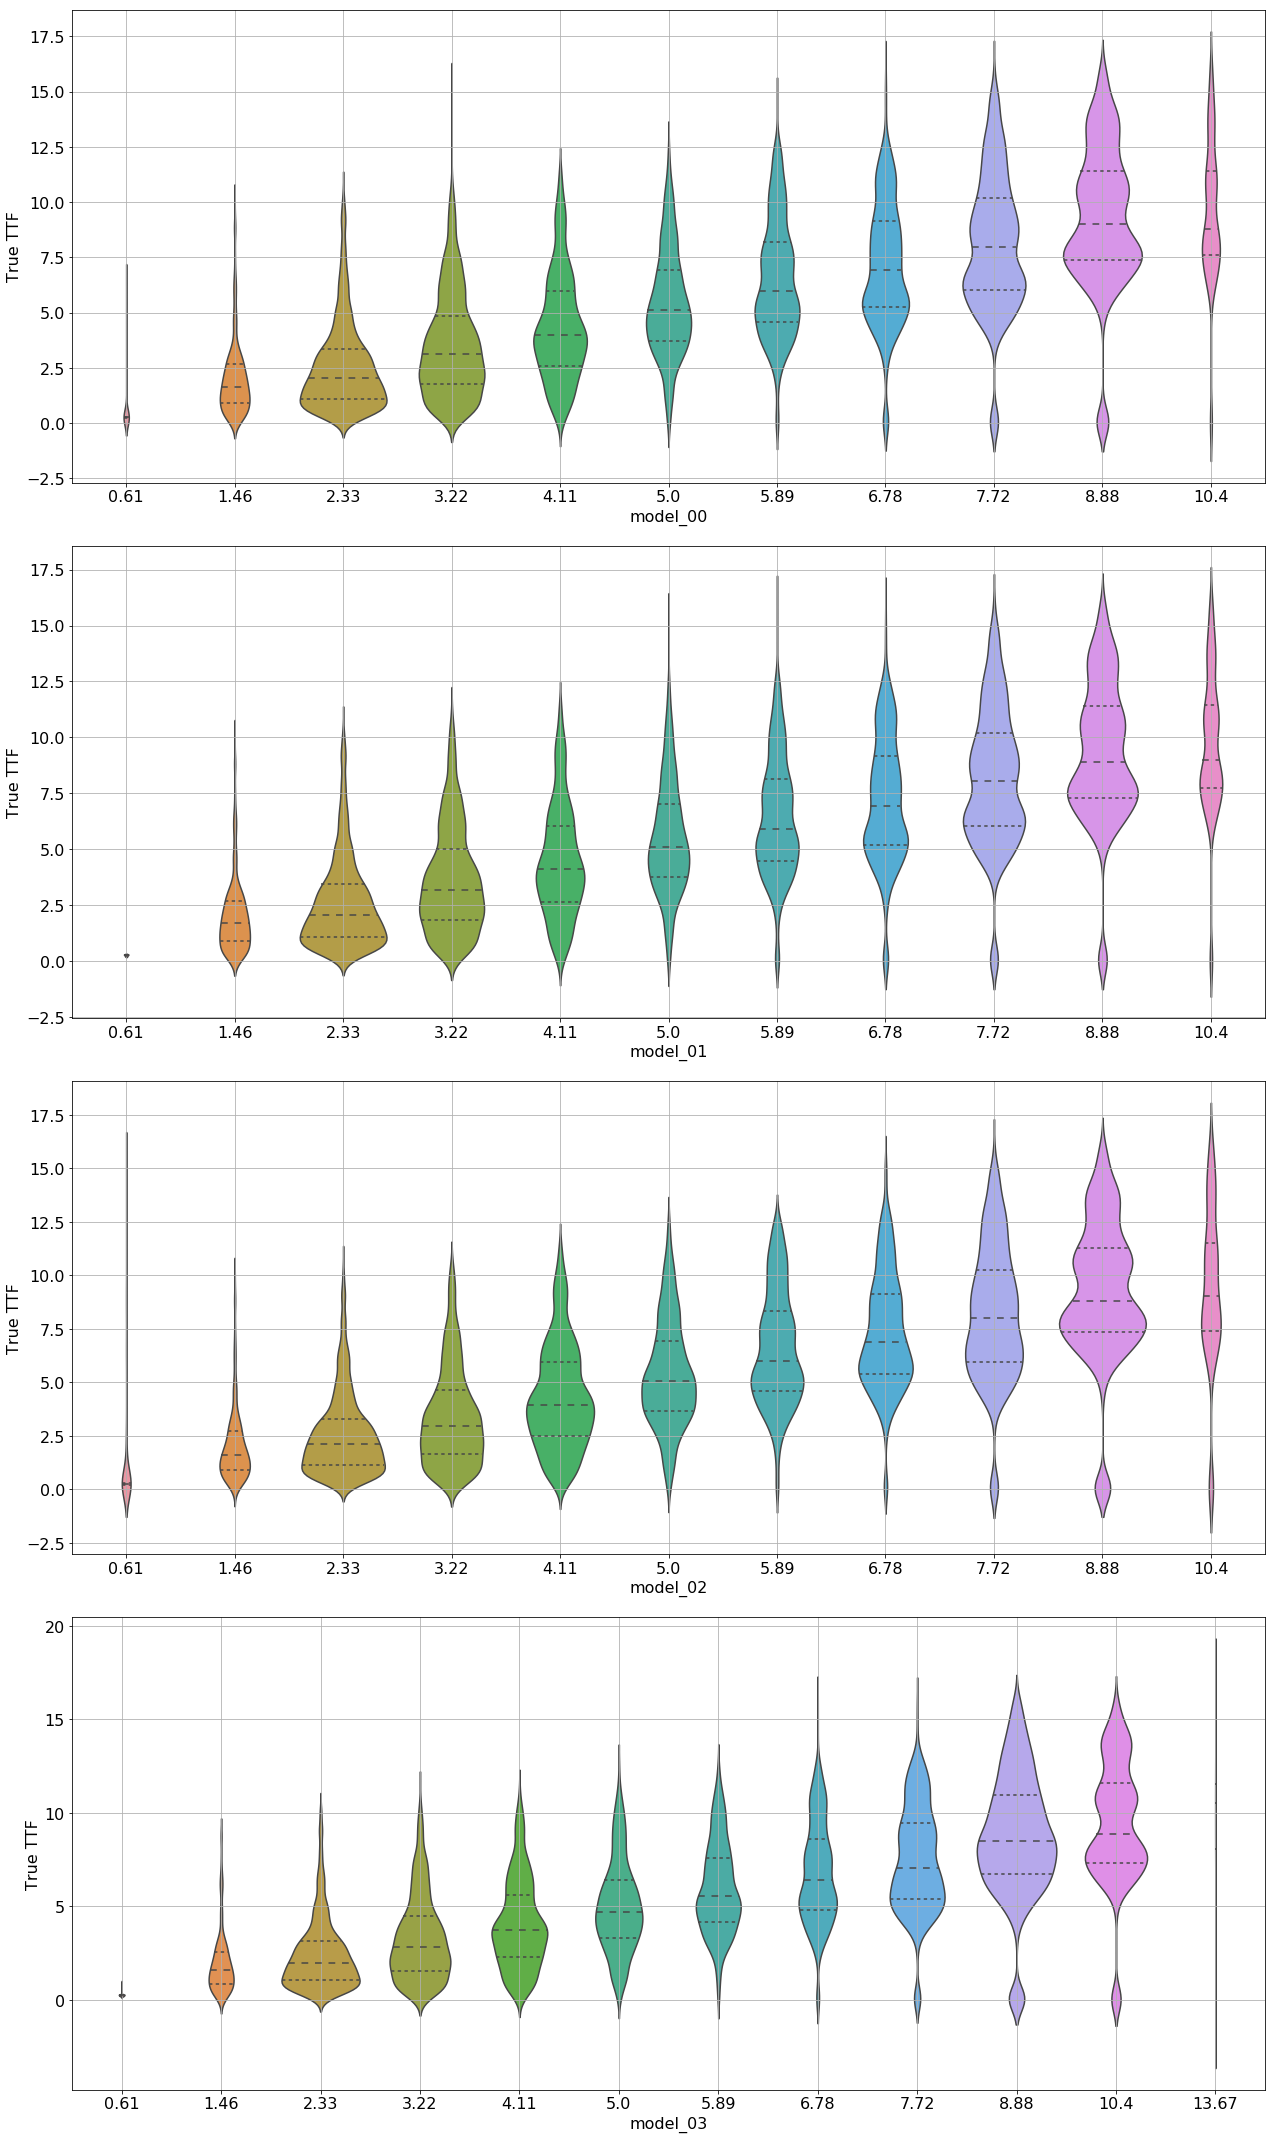

In [41]:
fig, axs = plt.subplots(n_est,1, figsize=(18,30))

for i,m in enumerate(estimates):
    ax = axs[i]
    pred_class = [np.sum(t>=thresholds) for t in preds[m]]
    pred_class = np.array(list(map(lambda i: (thresholds[i-1]+thresholds[i])/2, pred_class)))
    sns.violinplot(data=pd.DataFrame({m:pred_class.round(2),'True TTF':meta.qt}), x=m, y='True TTF',
                   ax=ax, inner='quart', scale='count')
    ax.grid()
    
plt.tight_layout()

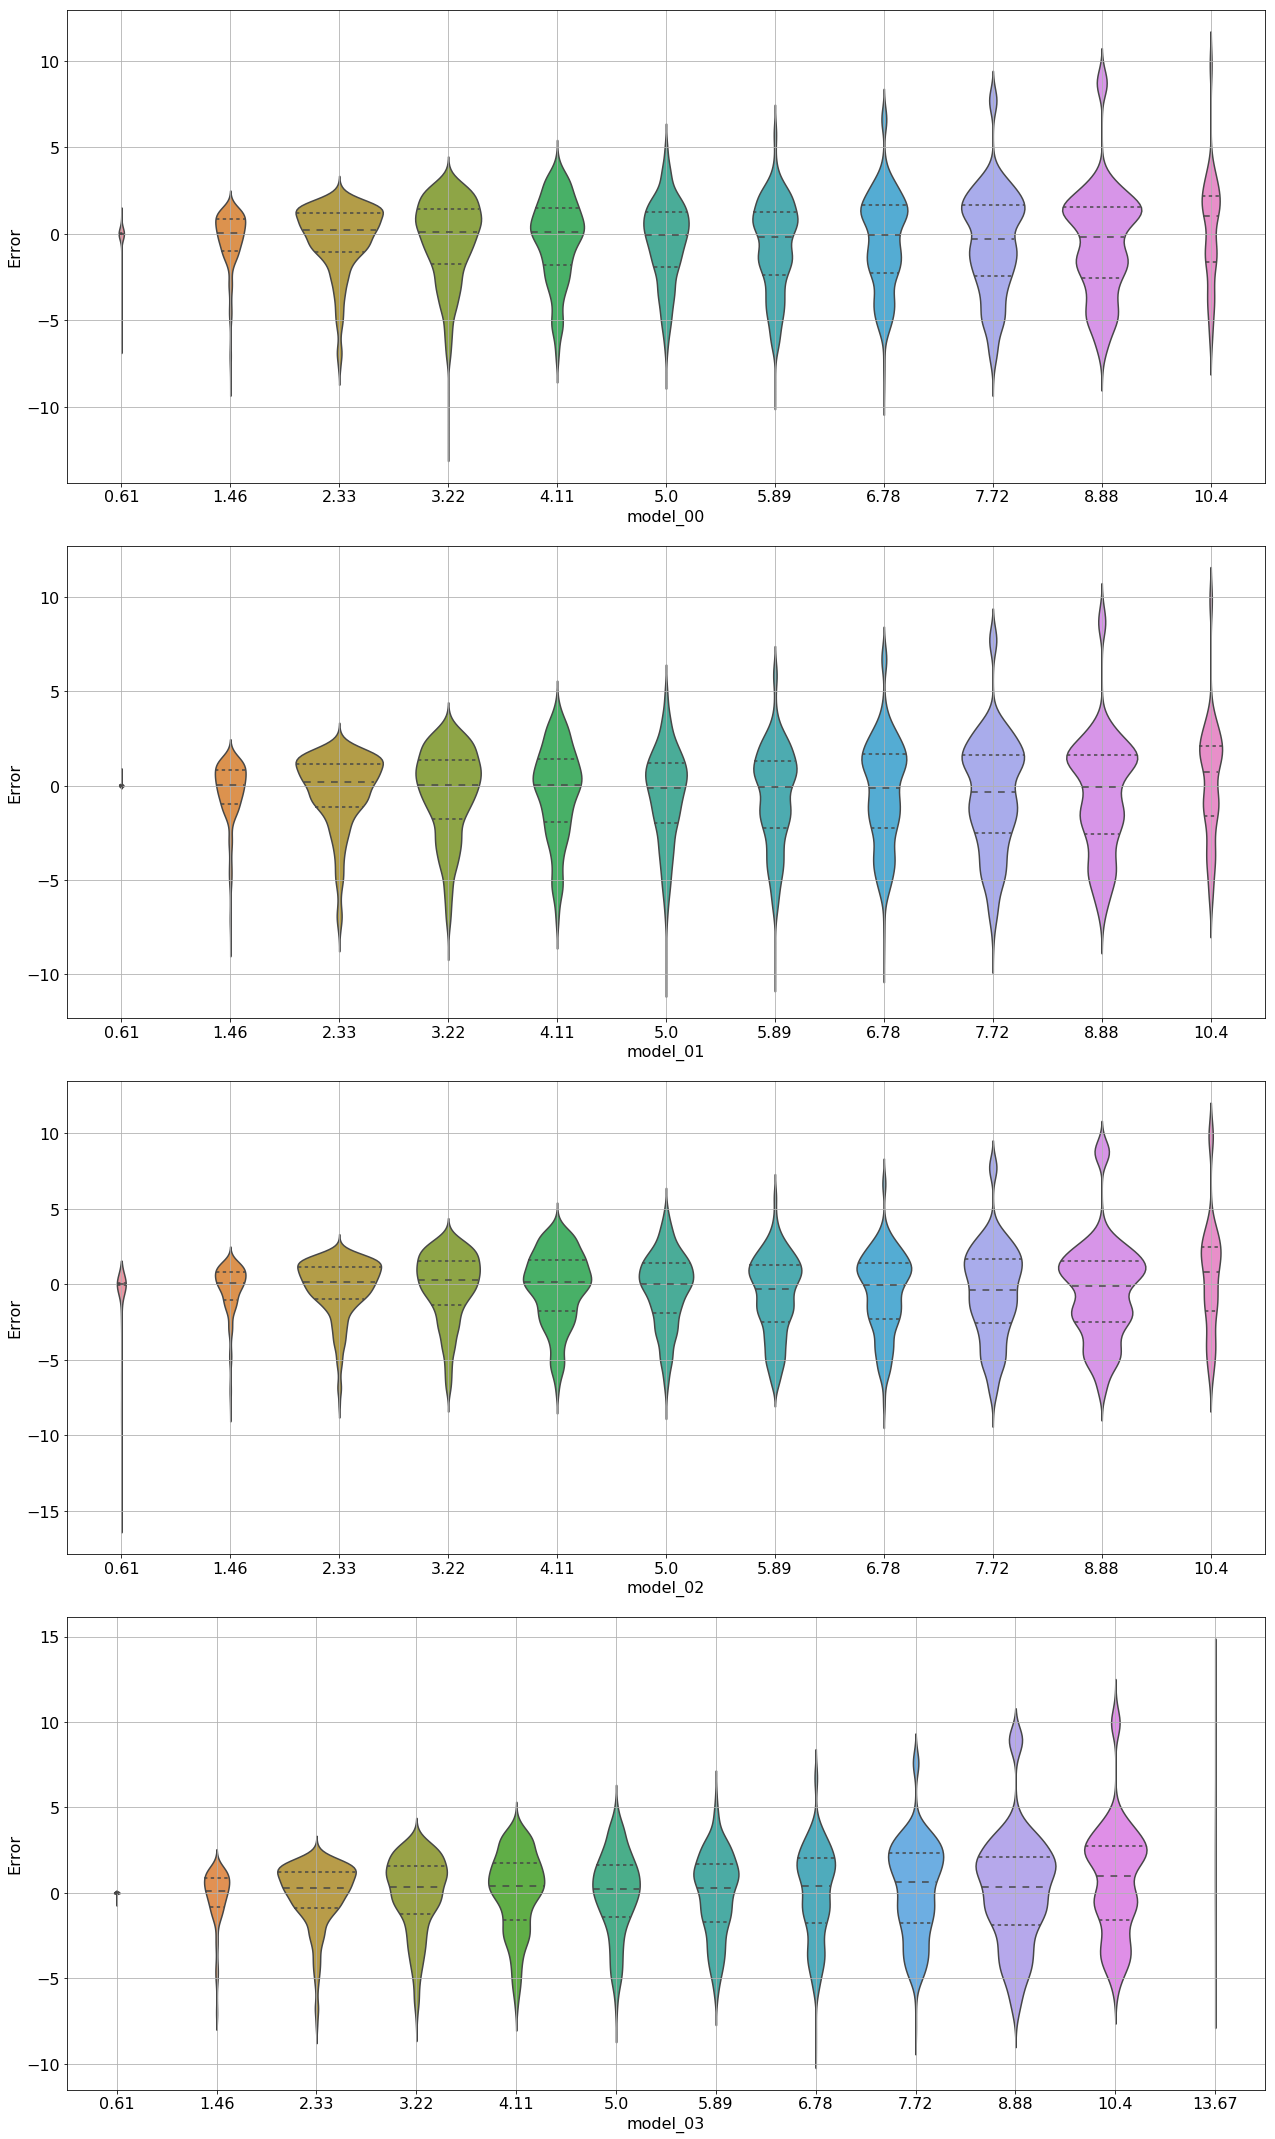

In [42]:
fig, axs = plt.subplots(n_models,1, figsize=(18,30))

for i,m in enumerate(models):
    ax = axs[i]
    pred_class = [np.sum(t>=thresholds) for t in preds[m]]
    pred_class = np.array(list(map(lambda i: (thresholds[i-1]+thresholds[i])/2, pred_class)))
    sns.violinplot(data=pd.DataFrame({m:pred_class.round(2),'Error':preds[m]-meta.qt}), x=m, y='Error',
                   ax=ax, inner='quart', scale='count')
    ax.grid()
    
plt.tight_layout()

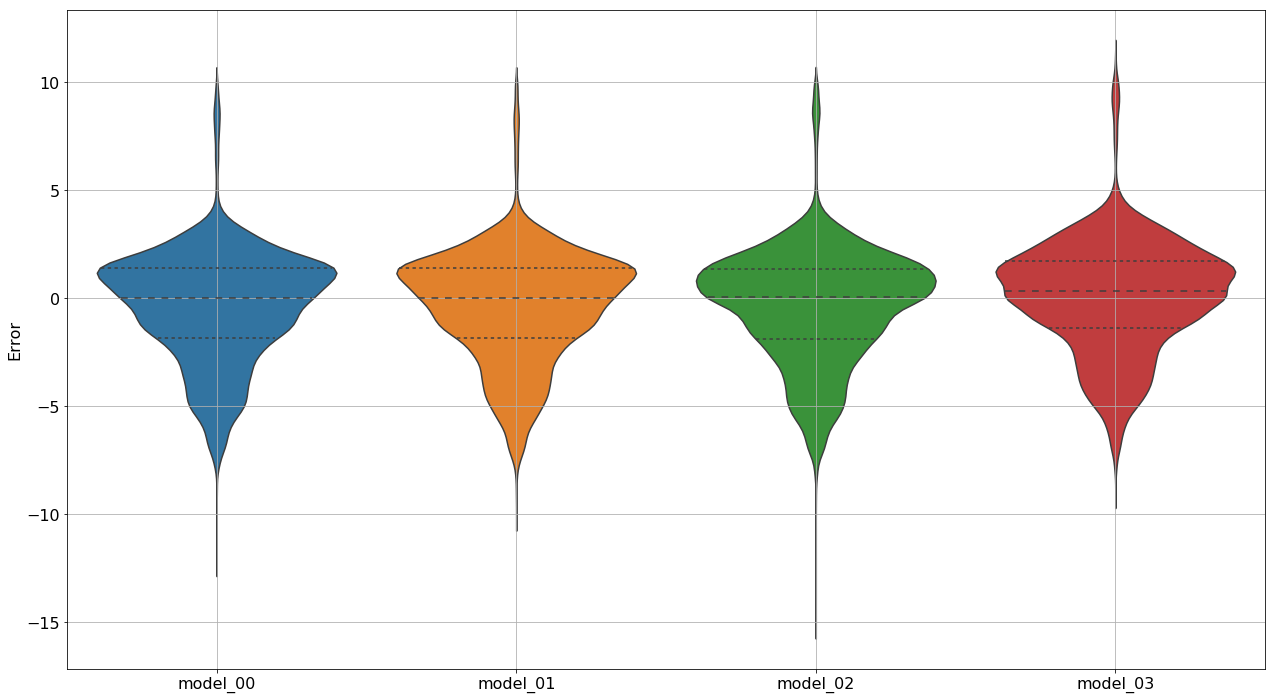

In [43]:
fig, axs = plt.subplots(1,1, figsize=(18,10))

ax = axs
sns.violinplot(data=preds[estimates].apply(lambda c: c-meta.qt, 0), ax=ax, inner='quart', scale='count')
ax.set_ylabel('Error')
ax.grid()
    
plt.tight_layout()

In [44]:
gc.collect()

19043